# Guía Práctica de Machine Learning

El objetivo es aprender utilizar SparkML para entrenar modelos de aprendizaje supervisado a gran escala. Apache Spark es ideal para procesar grandes volúmenes de datos y ejecutar algoritmos de machine learning de forma distribuida.


## Contenido
- Introducción
- Instalación 
- Conjunto de Datos
- Preprocesamiento
- Construcción de Modelos Supervisados
- Evaluación 

# Introducción a SparkML

SparkML es una librería de machine learning para procesamiento distribuido de big data, destacando por:

- Procesamiento paralelo en clusters
- Manejo eficiente de grandes volúmenes de datos  
- Escalabilidad horizontal

## Comparación con Scikit-learn

| Característica | SparkML | Scikit-learn |
|----------------|---------|--------------|
| Escala | Big data | Pequeña/mediana |
| Procesamiento | Distribuido | Local |
| Datos | Soporta formatos dispersos | Formatos densos |
| Uso | Complejo pero potente | Simple y directo |
| Integración | Ecosistema Hadoop | Standalone |

SparkML es ideal para proyectos que requieren procesar datasets masivos aprovechando recursos computacionales distribuidos.



In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkML").getOrCreate()



# Carga del Dataset

Utilizaremos el dataset "Data Science Salaries 2023" en formato Parquet:

In [0]:
# Especifica la ruta del archivo Parquet en DBFS
parquet_file_path = 'dbfs:/FileStore/datos/ds_salaries.parquet'

# Lee el archivo Parquet en un DataFrame de Spark
df = spark.read.parquet(parquet_file_path)


Ahora que los datos están cargados en el DataFrame `df`, podemos examinar su contenido:

In [0]:
df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

Ver el esquema y tipos de datos del DataFrame:

In [0]:
df.printSchema()

root
 |-- work_year: long (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: long (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: long (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: long (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



# Descripción de Variables del Dataset

- `work_year`: Año en que se pagó el salario.
- `experience_level`: Nivel de experiencia en el puesto durante el año.
- `employment_type`: Tipo de contrato laboral.
- `job_title`: Rol desempeñado durante el año.
- `salary`: Monto total del salario bruto pagado.
- `salary_currency`: Moneda del salario según código ISO 4217.
- `salary_in_usd`: Salario convertido a dólares estadounidenses.
- `employee_residence`: País de residencia del empleado durante el año laboral (código ISO 3166).
- `remote_ratio`: Porcentaje de trabajo realizado remotamente.
- `company_location`: País de la oficina principal o sucursal contratante.
- `company_size`: Número promedio de empleados en la empresa durante el año.

# Análisis Exploratorio de Datos

El análisis exploratorio es un paso fundamental antes de construir cualquier modelo. Nos permite:
- Entender el conjunto de datos
- Identificar aspectos importantes
- Obtener insights valiosos

In [0]:
df.describe().show()

+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|summary|         work_year|experience_level|employment_type|           job_title|            salary|salary_currency|     salary_in_usd|employee_residence|      remote_ratio|company_location|company_size|
+-------+------------------+----------------+---------------+--------------------+------------------+---------------+------------------+------------------+------------------+----------------+------------+
|  count|              3755|            3755|           3755|                3755|              3755|           3755|              3755|              3755|              3755|            3755|        3755|
|   mean|2022.3736351531293|            null|           null|                null|190695.57177097205|           null|137570.38988015978|              null|46.271637816245004|      

Veamos cuántos valores únicos tiene cada columna categórica:

In [0]:
from pyspark.sql.functions import col

for column in df.columns:
    if str(df.schema[column].dataType) in ['StringType()']:
       print(f"Número de valores únicos en {column}: {df.select(col(column)).distinct().count()}")


Número de valores únicos en experience_level: 4
Número de valores únicos en employment_type: 4
Número de valores únicos en job_title: 93
Número de valores únicos en salary_currency: 20
Número de valores únicos en employee_residence: 78
Número de valores únicos en company_location: 72
Número de valores únicos en company_size: 3


Comprender la cantidad de valores únicos en cada columna categórica puede ayudarnos a determinar si debemos utilizar la codificación one-hot u otras técnicas de codificación al preprocesar los datos para nuestros modelos de aprendizaje automático.

Ahora, examinemos la correlación entre las variables numéricas. Esto se puede hacer calculando la matriz de correlación.

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np

# Seleccionar columnas numéricas para el vector assembler
numeric_data = df.select(df["work_year"], df["salary"], df["salary_in_usd"], df["remote_ratio"])

# Eliminar valores NA
numeric_data = numeric_data.dropna()

# Crear el vector assembler
vectorAssembler = VectorAssembler(inputCols=numeric_data.columns, outputCol="numeric_data")

# Transformar los datos numéricos
df_vector = vectorAssembler.transform(numeric_data).select("numeric_data")

# Obtener la matriz de correlación
matrix = Correlation.corr(df_vector, "numeric_data")

# Obtener los valores de correlación
correlation_values = matrix.collect()[0]["pearson({})".format("numeric_data")].values

# Reorganizar los valores de correlación en una matriz
correlation_matrix = np.reshape(correlation_values, (4, 4))

# Imprimir la matriz de correlación
print(correlation_matrix)

[[ 1.         -0.09472389  0.22829002 -0.23642984]
 [-0.09472389  1.         -0.02367581  0.02873085]
 [ 0.22829002 -0.02367581  1.         -0.06417099]
 [-0.23642984  0.02873085 -0.06417099  1.        ]]


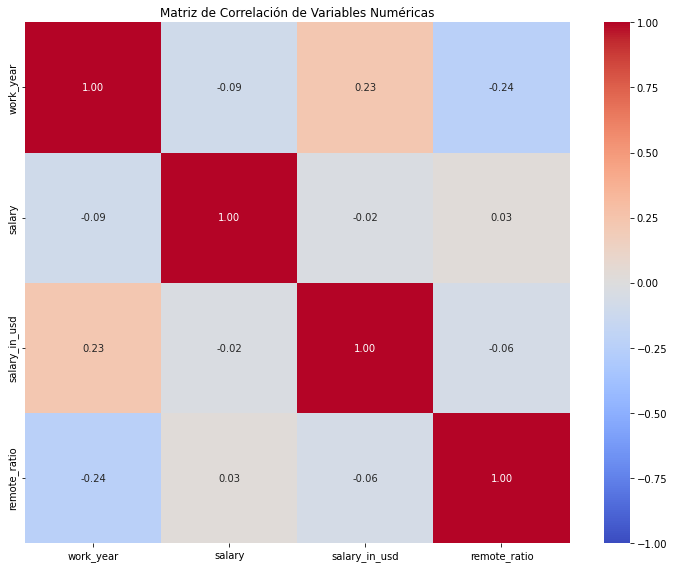

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar columnas numéricas
numeric_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
df_numeric = df.select(numeric_cols).toPandas()

# Calcular matriz de correlación
corr_matrix = df_numeric.corr()

# Crear mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,center=0, fmt='.2f')   

plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

Con base en esta matriz de correlación, podemos concluir lo siguiente:

- **`work_year`** (Años de trabajo) presenta una correlación positiva de 0,228 con **`salary_in_usd`** (Salario en USD), lo que indica que a medida que aumentan los años de experiencia laboral, el salario en USD tiende a incrementarse. Sin embargo, esta correlación no es muy fuerte.

- **`work_year`** también tiene una correlación negativa de -0,236 con **`remote_ratio`** (Proporción de trabajo remoto), lo que sugiere que a medida que aumentan los años de experiencia laboral, la proporción de trabajo remoto tiende a disminuir, y viceversa. Esta correlación también es moderada.

- Las correlaciones entre **`work_year`** y **`salary`**, **`salary`** y **`salary_in_usd`**, así como **`salary`** y **`remote_ratio`** son relativamente débiles (cercanas a 0), lo que indica que no existe una relación lineal fuerte entre estas variables.

- Las variables **`salary`** y **`salary_in_usd`** tienen una correlación negativa muy débil (-0,023), al igual que la correlación entre **`salary_in_usd`** y **`remote_ratio`** (-0,064).

- Existe una correlación positiva muy débil entre **`salary`** y **`remote_ratio`** (0,028).

A partir de estas observaciones, podemos concluir que **`work_year`** muestra las relaciones más significativas (aunque moderadas) con **`salary_in_usd`** y **`remote_ratio`**. No obstante, ninguna de las variables muestra una correlación fuerte, por lo que al construir el modelo será necesario considerar otras características, como las variables categóricas y sus posibles interacciones.


Vamos a analizar algunas de las variables categóricas con más detalle. Para ello, visualizaremos la distribución de los títulos de trabajo y las residencias de los empleados. Es importante tener en cuenta que utilizaremos las bibliotecas `matplotlib` y `seaborn` para crear las visualizaciones, por lo que primero convertiremos el DataFrame de Spark a un DataFrame de Pandas.


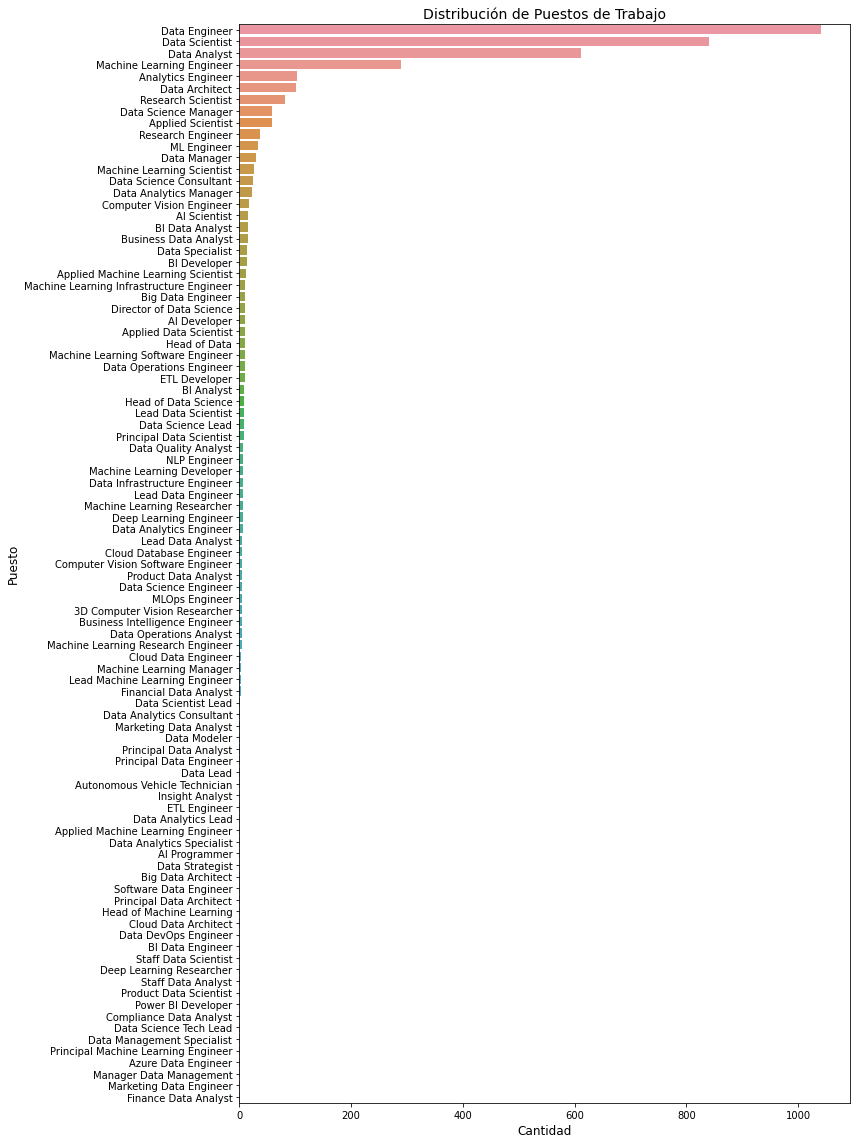

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir datos
df_pandas = df.toPandas()

# Crear gráfico de barras horizontal
plt.figure(figsize=(12,16))
ax = sns.countplot(y='job_title', 
                   data=df_pandas,
                   order=df_pandas['job_title'].value_counts().index)

# Personalizar gráfico
plt.title('Distribución de Puestos de Trabajo', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Puesto', fontsize=12)

# Mostrar gráfico
plt.tight_layout()
plt.show()

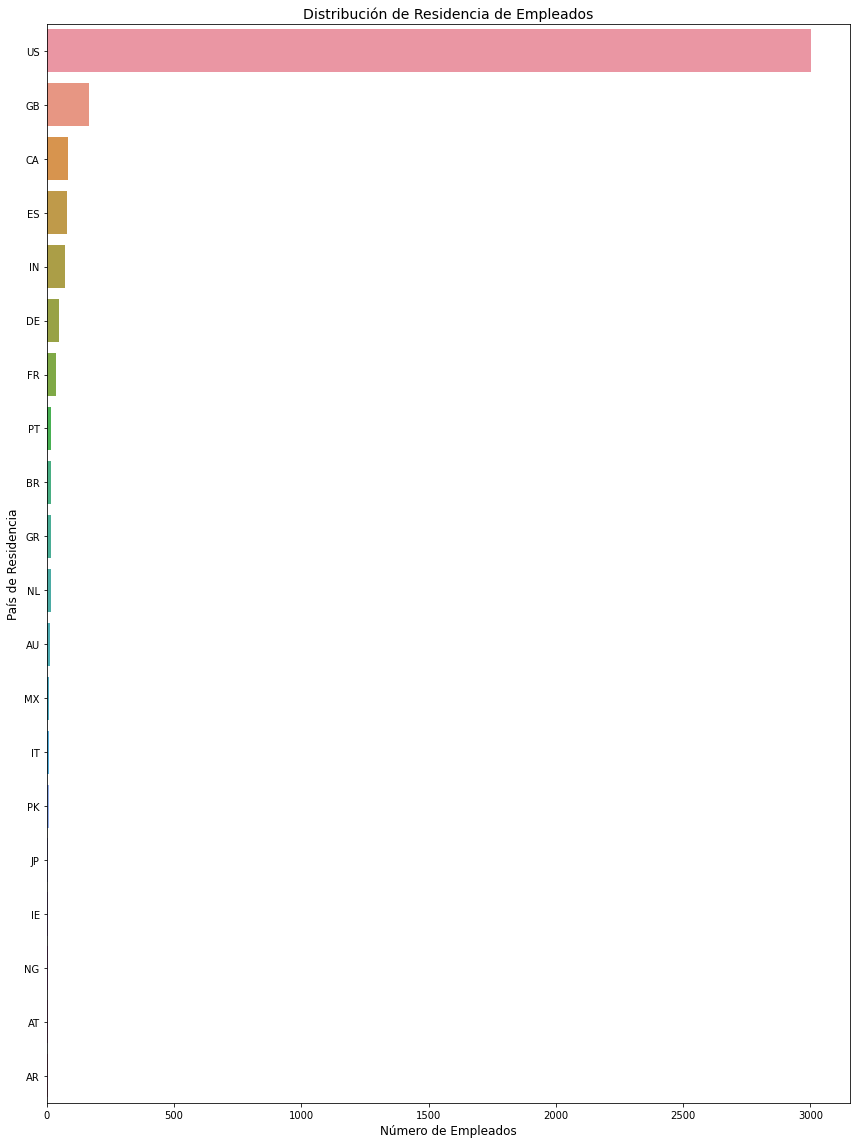

In [0]:

# Graficar distribución de países de residencia
plt.figure(figsize=(12,16))
ax = sns.countplot(y='employee_residence',
                  data=df_pandas,
                  order=df_pandas['employee_residence'].value_counts().head(20).index) # Top 20 países

# Personalizar gráfico
plt.title('Distribución de Residencia de Empleados', fontsize=14)
ax.set_xlabel('Número de Empleados', fontsize=12)
ax.set_ylabel('País de Residencia', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()


Como puede ver, tenemos más datos para EE. UU.: filtremos los datos para predecir los empleados con sede en EE. UU.:

In [0]:
df = df.filter(df.employee_residence == 'US')
df.printSchema()

root
 |-- work_year: long (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- salary: long (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary_in_usd: long (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- remote_ratio: long (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



In [0]:
for column in df.columns:
    if str(df.schema[column].dataType) in ['StringType()']:
        print(f"Número de valores únicos en {column}: {df.select(col(column)).distinct().count()}")


Número de valores únicos en experience_level: 4
Número de valores únicos en employment_type: 3
Número de valores únicos en job_title: 70
Número de valores únicos en salary_currency: 1
Número de valores únicos en employee_residence: 1
Número de valores únicos en company_location: 6
Número de valores únicos en company_size: 3


So filtering data to US, required to remove some of reducntant columns. Let's remove `employee_residence`, `salary_currency` (as all in USD), and `salary` (`salary` will be same as `salary_in_usd` after filtering):

In [0]:
# Ahora podemos eliminar employee_residence
df = df.drop('employee_residence')
df = df.drop('salary_currency')
df = df.drop('salary')

Let's check the count of each column one more time:

In [0]:
for column in df.columns:
    if str(df.schema[column].dataType) in ['StringType()']:
        print(f"Número de valores únicos en {column}: {df.select(col(column)).distinct().count()}")


Number of unique values in experience_level: 4
Number of unique values in employment_type: 3
Number of unique values in job_title: 70
Number of unique values in company_location: 6
Number of unique values in company_size: 3


In [0]:
df.show()

+---------+----------------+---------------+--------------------+-------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary_in_usd|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+-------------+------------+----------------+------------+
|     2023|              MI|             CT|         ML Engineer|        30000|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer|        25500|         100|              US|           S|
|     2023|              SE|             FT|   Applied Scientist|       222200|           0|              US|           L|
|     2023|              SE|             FT|   Applied Scientist|       136000|           0|              US|           L|
|     2023|              SE|             FT|      Data Scientist|       147100|           0|              US|           M|
|     2023|     

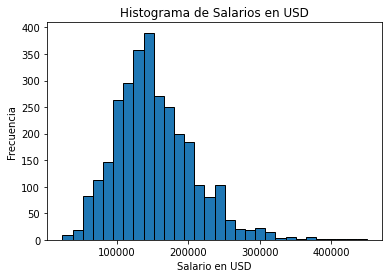

In [0]:
# Convertir DataFrame de Spark a DataFrame de Pandas
pandas_df = df.select('salary_in_usd').toPandas()

# Crear un histograma
plt.hist(pandas_df['salary_in_usd'], bins=30, edgecolor='black')

# Establecer el título y las etiquetas
plt.title('Histograma de Salarios en USD')
plt.xlabel('Salario en USD') 
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

In [0]:
df

Out[208]: DataFrame[work_year: bigint, experience_level: string, employment_type: string, job_title: string, salary_in_usd: bigint, remote_ratio: bigint, company_location: string, company_size: string]

# Preprocesamiento de Datos

El preprocesamiento de datos es un paso crucial en el pipeline de machine learning. Implica limpiar los datos y transformarlos en un formato utilizable por los algoritmos.

## Manejo de Valores Faltantes

Primero trataremos los valores faltantes. El DataFrame de PySpark proporciona la propiedad `na` (una instancia de DataFrameNaFunctions) con funciones útiles para manejar datos faltantes o nulos.



In [0]:
df = df.na.drop()

## Eliminación de Duplicados

La función `dropDuplicates()` de PySpark permite eliminar registros duplicados del DataFrame. Sin argumentos, elimina las filas que tienen valores idénticos en todas las columnas.


In [0]:
# Contar registros antes de eliminar duplicados
total_antes = df.count()
print(f"Total de registros antes de eliminar duplicados: {total_antes}")

# Eliminar duplicados
df = df.dropDuplicates()

# Contar registros después de eliminar duplicados 
total_despues = df.count()
print(f"Total de registros después de eliminar duplicados: {total_despues}")

# Calcular duplicados eliminados
print(f"Número de duplicados eliminados: {total_antes - total_despues}")

Total de registros antes de eliminar duplicados: 3004
Total de registros después de eliminar duplicados: 1893
Número de duplicados eliminados: 1111


In [0]:
df.show()

+---------+----------------+---------------+------------------+-------------+------------+----------------+------------+
|work_year|experience_level|employment_type|         job_title|salary_in_usd|remote_ratio|company_location|company_size|
+---------+----------------+---------------+------------------+-------------+------------+----------------+------------+
|     2023|              SE|             FT|     Data Engineer|       107900|         100|              US|           M|
|     2023|              SE|             FT|     Data Engineer|       124740|           0|              US|           M|
|     2023|              SE|             FT|     Data Engineer|       265000|           0|              US|           M|
|     2022|              EN|             FT|     Data Engineer|       160000|           0|              US|           M|
|     2022|              SE|             FT|     Data Engineer|        75000|           0|              US|           M|
|     2022|              SE|    

## De Regresión a Clasificación

Convertiremos el problema de regresión (predicción de 'salary_in_usd') en uno de clasificación utilizando rangos salariales. Para esto, usaremos los tramos fiscales federales de EE.UU. de 2023.

### Proceso
1. Identificar salario mínimo y máximo en el dataset
2. Establecer rangos salariales basados en tramos fiscales
3. Crear variable categórica 'income_bracket'
4. Asignar clases del 1 al 4 según el rango salarial

### Rangos Definidos
- **Clase 1**: $44,725 - $95,375
- **Clase 2**: $95,376 - $182,100
- **Clase 3**: $182,101 - $231,250
- **Clase 4**: > $231,250

Esta transformación simplifica el problema y permite utilizar algoritmos de clasificación.

In [0]:
from pyspark.sql import functions as F

# Obtener salario mínimo y máximo
salario_min = df.agg(F.min(df.salary_in_usd)).first()[0]
salario_max = df.agg(F.max(df.salary_in_usd)).first()[0]

print(f"Salario Mínimo: {salario_min}")
print(f"Salario Máximo: {salario_max}")

Salario Mínimo: 24000
Salario Máximo: 450000


## Rangos Salariales para Clasificación

Se utilizarán los tramos fiscales del 2023 para contribuyentes individuales:

### Clases Definidas:
1. **Clase 1**: $44,725 - $95,375
2. **Clase 2**: $95,376 - $182,100
3. **Clase 3**: $182,101 - $231,250
4. **Clase 4**: > $231,250

Nota: Los valores están basados en los tramos fiscales federales de Estados Unidos para declarantes individuales del año 2023.

In [0]:
from pyspark.sql.functions import when

# Definir los rangos salariales
rangos = [(95375, 1), (182100, 2), (231250, 3)]

# Comenzar desde el rango más alto
df = df.withColumn("income_bracket", when(df["salary_in_usd"] > 231250, 4))

# Iterar sobre el resto de rangos
for rango, etiqueta in reversed(rangos):
   df = df.withColumn("income_bracket", 
                     when(df["salary_in_usd"] <= rango, etiqueta)
                     .otherwise(df["income_bracket"]))

In [0]:
df = df.drop('salary_in_usd')

Let's see classes

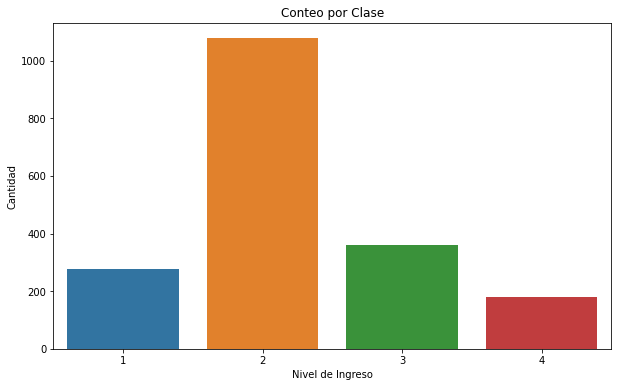

In [0]:
import seaborn as sns

# Primero, agrupar por columna 'income_bracket' y contar
class_counts = df.groupBy("income_bracket").count().orderBy('income_bracket').toPandas()

# Graficar el conteo de cada clase
plt.figure(figsize=(10,6))
sns.barplot(x='income_bracket', y='count', data=class_counts)
plt.title('Conteo por Clase')
plt.xlabel('Nivel de Ingreso')
plt.ylabel('Cantidad')
plt.show()

## Procesamiento de Variables Categóricas


A continuación, procesaremos las variables categóricas. La mayoría de los modelos de machine learning requieren entrada numérica. Por lo tanto, necesitamos convertir las variables categóricas a formato numérico. Esto se puede lograr mediante Codificación One-Hot o Indexación de Cadenas.

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexación para columnas categóricas
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in df.columns if str(df.schema[column].dataType) == 'StringType()']

# Codificación para columnas categóricas
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol= column+"_ohe") for column in df.columns if str(df.schema[column].dataType) == 'StringType()']

# Etapas del pipeline
stages = indexers + encoders

# Agregar indexadores y codificadores en un pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=stages)

# Transformar datos
df = pipeline.fit(df).transform(df)
df.printSchema()

root
 |-- work_year: long (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- remote_ratio: long (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_index: double (nullable = false)
 |-- employment_type_index: double (nullable = false)
 |-- job_title_index: double (nullable = false)
 |-- company_location_index: double (nullable = false)
 |-- company_size_index: double (nullable = false)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)




## Limpieza de Columnas Post-Codificación

Después del proceso de codificación, tenemos varias columnas nuevas con sufijos `_index` o `_ohe`. Para mantener nuestro DataFrame organizado, podemos eliminar:

1. Columnas originales categóricas
2. Columnas intermedias con sufijo `_index`
3. Columnas redundantes

Esto nos dejará solo con las variables numéricas originales y las nuevas columnas codificadas relevantes para el modelo.

In [0]:
# Eliminar columnas categóricas originales
for column in df.columns:
   if str(df.schema[column].dataType) == 'StringType()':
       df = df.drop(column)

df.printSchema()

root
 |-- work_year: long (nullable = true)
 |-- remote_ratio: long (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_index: double (nullable = false)
 |-- employment_type_index: double (nullable = false)
 |-- job_title_index: double (nullable = false)
 |-- company_location_index: double (nullable = false)
 |-- company_size_index: double (nullable = false)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)



In [0]:
df.show()

+---------+------------+--------------+----------------------+---------------------+---------------+----------------------+------------------+--------------------+-------------------+---------------+--------------------+----------------+
|work_year|remote_ratio|income_bracket|experience_level_index|employment_type_index|job_title_index|company_location_index|company_size_index|experience_level_ohe|employment_type_ohe|  job_title_ohe|company_location_ohe|company_size_ohe|
+---------+------------+--------------+----------------------+---------------------+---------------+----------------------+------------------+--------------------+-------------------+---------------+--------------------+----------------+
|     2023|         100|             2|                   0.0|                  0.0|            0.0|                   0.0|               0.0|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             2|         

## Estructura de Vectores Dispersos en PySpark

En PySpark ML, cuando trabajamos con datos de alta dimensionalidad, se utiliza una representación eficiente llamada vectores dispersos (sparse vectors).

### Ejemplo de Representación
Estructura: `(3,[0],[1.0])`
- Primer número (3): Tamaño total del vector
- Segunda lista [0]: Índices donde hay valores no-cero
- Tercera lista [1.0]: Valores correspondientes a esos índices

### Interpretación
El vector `(3,[0],[1.0])` representa:
- Vector completo: [1.0, 0.0, 0.0]
- Longitud: 3 elementos
- Solo el índice 0 tiene valor no-cero (1.0)

### Ventajas
1. Ahorro de memoria
2. Eficiencia en procesamiento
3. Ideal para datos categóricos codificados
4. Optimizado para variables con muchos niveles

## Eliminar Columnas Intermedias

En el procesamiento de variables categóricas, después de aplicar la codificación one-hot, generalmente no es necesario mantener las columnas indexadas intermedias creadas por StringIndexer. Estas columnas son solo un paso temporal en el proceso de transformación para convertir valores categóricos de texto a números.

### Razones para eliminar:
1. Evitar redundancia en los datos
2. Prevenir problemas de multicolinealidad
3. Optimizar el espacio de almacenamiento
4. Simplificar el conjunto de datos final

In [0]:
# Eliminar columnas categóricas originales y columnas índice
for column in df.columns:
   if column.endswith('_index'):
       df = df.drop(column)

df.printSchema()

root
 |-- work_year: long (nullable = true)
 |-- remote_ratio: long (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- experience_level_ohe: vector (nullable = true)
 |-- employment_type_ohe: vector (nullable = true)
 |-- job_title_ohe: vector (nullable = true)
 |-- company_location_ohe: vector (nullable = true)
 |-- company_size_ohe: vector (nullable = true)



## Separar Características y Etiqueta

Ahora separaremos las características de la etiqueta 'income_bracket'. Crearemos una columna 'features' que combina todos los vectores de características.

In [0]:
df.show()

+---------+------------+--------------+--------------------+-------------------+---------------+--------------------+----------------+
|work_year|remote_ratio|income_bracket|experience_level_ohe|employment_type_ohe|  job_title_ohe|company_location_ohe|company_size_ohe|
+---------+------------+--------------+--------------------+-------------------+---------------+--------------------+----------------+
|     2023|         100|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             2|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2023|           0|             4|       (3,[0],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2022|           0|             2|       (3,[2],[1.0])|      (2,[0],[1.0])| (69,[0],[1.0])|       (5,[0],[1.0])|   (2,[0],[1.0])|
|     2022|           0|             1|       (3,[0],[1

In [0]:
from pyspark.ml.feature import VectorAssembler

# Definir las columnas de características
feature_columns = [column for column in df.columns if column != 'income_bracket']

# Separar características y variable objetivo
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df = assembler.transform(df)

# Seleccionar características y objetivo
df = df.select('features', 'income_bracket')

# Ver los datos transformados 
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- income_bracket: integer (nullable = true)



## Normalización de Características

Por último, normalizaremos los vectores de características para llevarlos a la misma escala usando StandardScaler. Esto ayuda a:

- Estandarizar el rango de las variables 
- Mejorar la convergencia del modelo
- Facilitar la comparación entre características

In [0]:
from pyspark.ml.feature import StandardScaler

# Inicializar el escalador estándar
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Calcular estadísticas resumen ajustando el StandardScaler
scalerModel = scaler.fit(df)

# Normalizar cada característica para tener desviación estándar unitaria
df = scalerModel.transform(df)

# Ver los datos transformados
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- income_bracket: integer (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [0]:
df.show()

+--------------------+--------------+--------------------+
|            features|income_bracket|     scaled_features|
+--------------------+--------------+--------------------+
|(83,[0,1,2,5,7,76...|             2|[0.88167637673935...|
|(83,[0,2,5,7,76,8...|             2|[0.88167637673935...|
|(83,[0,2,5,7,76,8...|             4|[0.88167637673935...|
|(83,[0,4,5,7,76,8...|             2|[-0.6622767973269...|
|(83,[0,2,5,7,76,8...|             1|[-0.6622767973269...|
|(83,[0,1,2,5,9,76...|             3|[-0.6622767973269...|
|(83,[0,1,2,5,12,7...|             4|[-0.6622767973269...|
|(83,[0,1,4,5,8,76...|             1|[-0.6622767973269...|
|(83,[0,2,5,11,76,...|             1|[-0.6622767973269...|
|(83,[0,2,5,30,76,...|             1|[-0.6622767973269...|
|(83,[0,1,4,5,9,76...|             2|[-0.6622767973269...|
|(83,[0,2,5,8,76,8...|             2|[0.88167637673935...|
|(83,[0,2,5,7,76,8...|             2|[0.88167637673935...|
|(83,[0,1,2,5,7,76...|             2|[0.88167637673935..

## Modelado

### División del conjunto de datos

Primero, dividiremos el dataset en conjuntos de entrenamiento y prueba:

In [0]:
# Train-test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [0]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Definir modelo base para OneVsRest
base_lr = LogisticRegression(featuresCol='features', labelCol='income_bracket')

# Definir los modelos base
base_classifiers = {
   "Logistic Regression": LogisticRegression(featuresCol='features', labelCol='income_bracket'),
   "Decision Tree Classifier": DecisionTreeClassifier(featuresCol='features', labelCol='income_bracket'),
   "Random Forest Classifier": RandomForestClassifier(featuresCol='features', labelCol='income_bracket'),
   "Naive Bayes": NaiveBayes(featuresCol='features', labelCol='income_bracket'),
   "OneVsRest": OneVsRest(classifier=base_lr, featuresCol='features', labelCol='income_bracket')
}

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='income_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='income_bracket', metricName="f1")

# Loop through models
for model_name, model in base_classifiers.items():
   # Fit the model
   model_fit = model.fit(train_data)

   # Predict on train and test data
   test_results = model_fit.transform(test_data)
   train_results = model_fit.transform(train_data)

   # Compute accuracy and F1 score
   accuracy = evaluator_accuracy.evaluate(test_results)
   f1 = evaluator_f1.evaluate(test_results)
   accuracy_train = evaluator_accuracy.evaluate(train_results)
   f1_train = evaluator_f1.evaluate(train_results)

   # Print evaluation metrics
   print(f"{model_name}: Train Accuracy = {accuracy_train}, Train F1 = {f1_train}")
   print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")

Logistic Regression: Train Accuracy = 0.6153846153846154, Train F1 = 0.5440410568073162
Logistic Regression: Test Accuracy = 0.5585585585585585, Test F1 = 0.4966884417102319
Decision Tree Classifier: Train Accuracy = 0.6019230769230769, Train F1 = 0.5118705330831265
Decision Tree Classifier: Test Accuracy = 0.5675675675675675, Test F1 = 0.48461021731569665
Random Forest Classifier: Train Accuracy = 0.5775641025641025, Train F1 = 0.4348089352997069
Random Forest Classifier: Test Accuracy = 0.5855855855855856, Test F1 = 0.44505756487053977
Naive Bayes: Train Accuracy = 0.12692307692307692, Train F1 = 0.10951574760092325
Naive Bayes: Test Accuracy = 0.11711711711711711, Test F1 = 0.10732322111632456
OneVsRest: Train Accuracy = 0.6134615384615385, Train F1 = 0.5391375912797332
OneVsRest: Test Accuracy = 0.5615615615615616, Test F1 = 0.5010545592163818



### Resultados

#### Random Forest Classifier (Mejor Rendimiento)
- Train Accuracy: 57.76%
- Test Accuracy: **58.56%**
- Train F1: 43.48%
- Test F1: 44.51%

#### OneVsRest
- Train Accuracy: 61.35%
- Test Accuracy: 56.16%
- Train F1: 53.91%
- Test F1: **50.11%**

#### Recomendación

Se recomienda usar el **Random Forest Classifier** por:
1. Mayor accuracy en test (58.56%)
2. Mejor balance entre métricas de train y test
3. Mayor estabilidad en predicciones generales

Como alternativa, el modelo **OneVsRest** ofrece el mejor F1-Score en test (50.11%), lo que lo hace preferible si el balance entre precisión y recall es prioritario.